In [1]:
### Imports ###

# General data manipulation and plotting packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.timeseries import LombScargle

# Exoplanet data packages
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Standard Python libraries
import os # Operating system interfaces
from urllib.request import urlretrieve # Query with links
import re # Regular expressions

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# Matplotlib settings
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts'] # This will not work for you since it is a local directory on my system
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

Retrieve data

In [6]:
### Retrieve planetary information ###

# Identify the planet and query the database 
planet_name = 'WASP-18 b'
NEA_result = NasaExoplanetArchive.query_object(planet_name)
TIC_id = NEA_result['tic_id'][0] # extracts the TESS Input Catalog ID number associated with the planet

# Extract orbital period (P), mid-transit time (t_0), and transit duration (t_dur)
ephemeris_ind, t_dur_ind = 1, 1
P, t_0, t_dur = NEA_result['pl_orbper'][ephemeris_ind], NEA_result['pl_tranmid'][ephemeris_ind], \
NEA_result['pl_trandur'][t_dur_ind].value*u.hour
print('Reference: ', NEA_result['pl_refname'][ephemeris_ind])
print('Transit duration reference: ', NEA_result['pl_refname'][t_dur_ind])
print('Period: ', P)
print('Mid-transit time: ', t_0)
print('Transit duration: ', t_dur)
t_0 = t_0 - 2457000.0*u.day

# Use lightkurve package to retrieve TESS photometry for this target
TESS_result = lk.search_lightcurve(TIC_id, mission='TESS', author='SPOC', exptime=120)

# Show sectors of data available for target
TESS_result

Reference:  <a refstr=HELLIER_ET_AL__2009 href=https://ui.adsabs.harvard.edu/abs/2009Natur.460.1098H/abstract target=ref> Hellier et al. 2009 </a>
Transit duration reference:  <a refstr=HELLIER_ET_AL__2009 href=https://ui.adsabs.harvard.edu/abs/2009Natur.460.1098H/abstract target=ref> Hellier et al. 2009 </a>
Period:  0.94145299 d
Mid-transit time:  2454221.48163 d
Transit duration:  2.14368 h


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,SPOC,120,100100827,0.0
2,TESS Sector 29,2020,SPOC,120,100100827,0.0
3,TESS Sector 30,2020,SPOC,120,100100827,0.0
4,TESS Sector 69,2023,SPOC,120,100100827,0.0


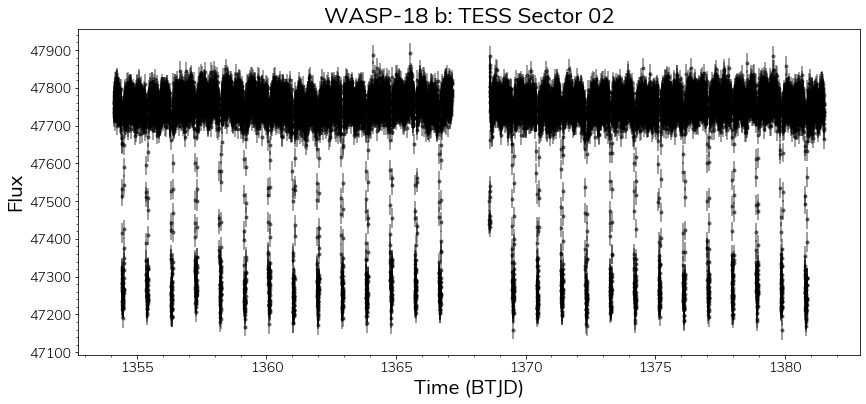

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


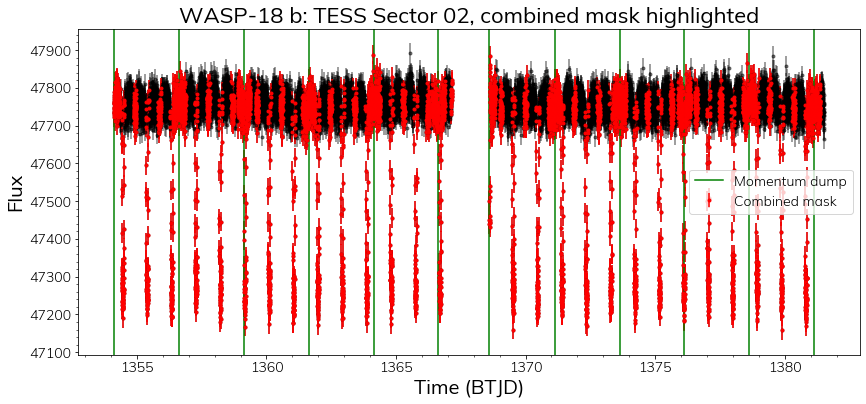

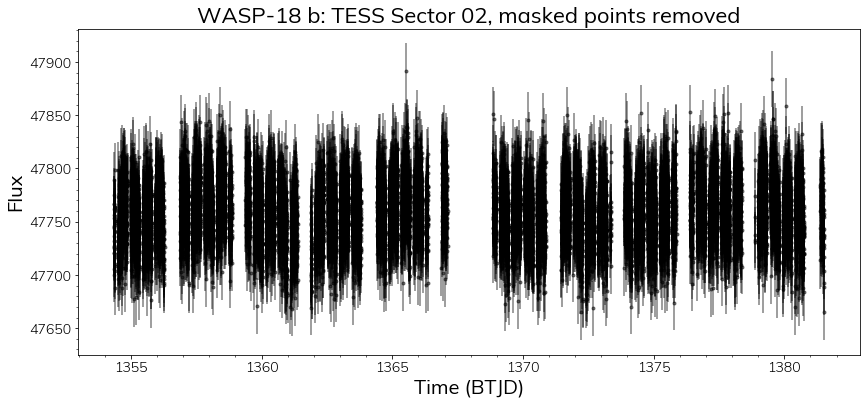

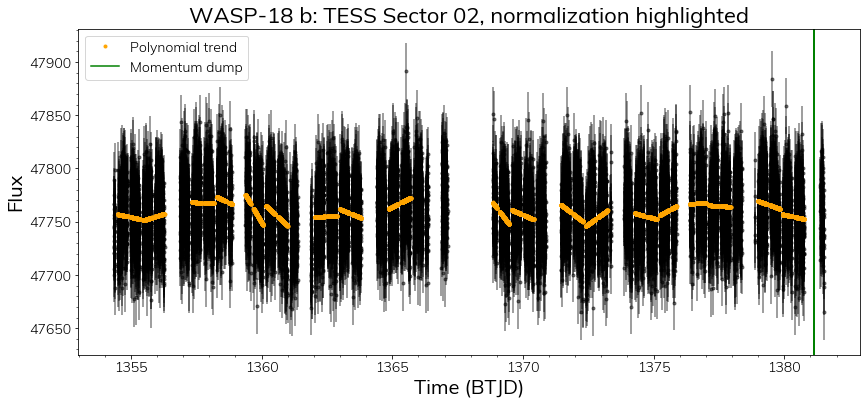

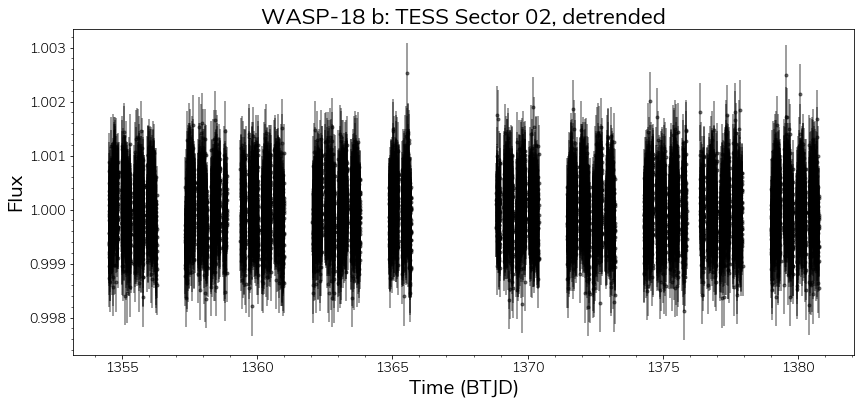

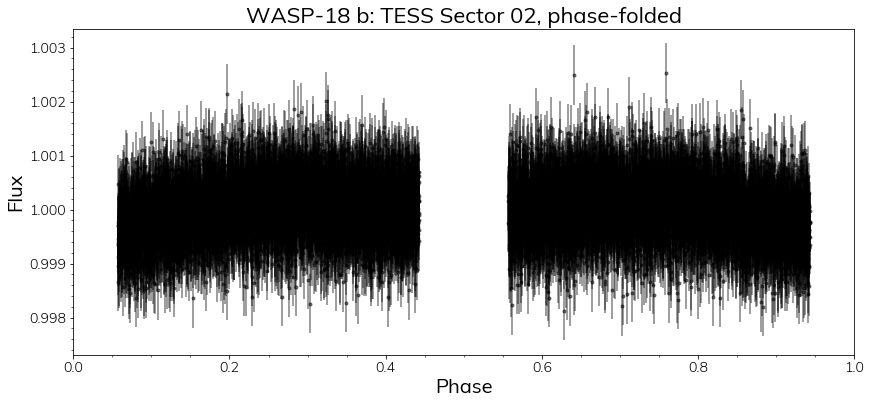

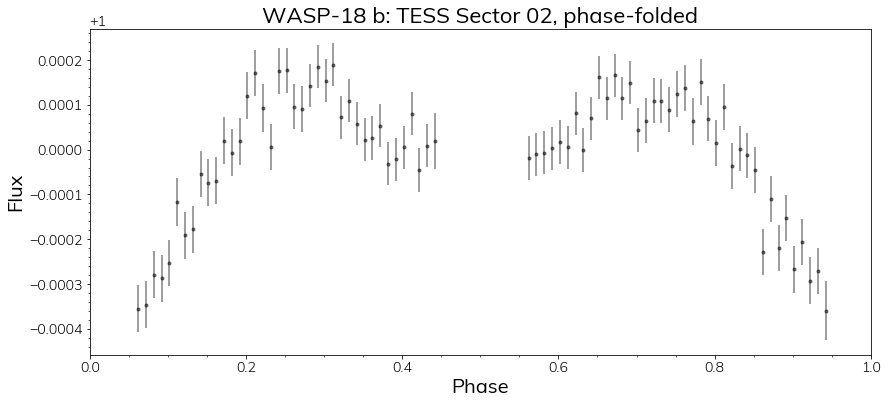

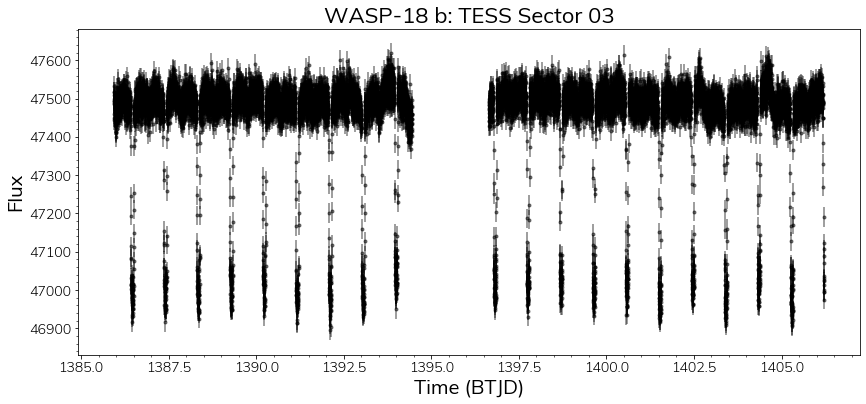

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


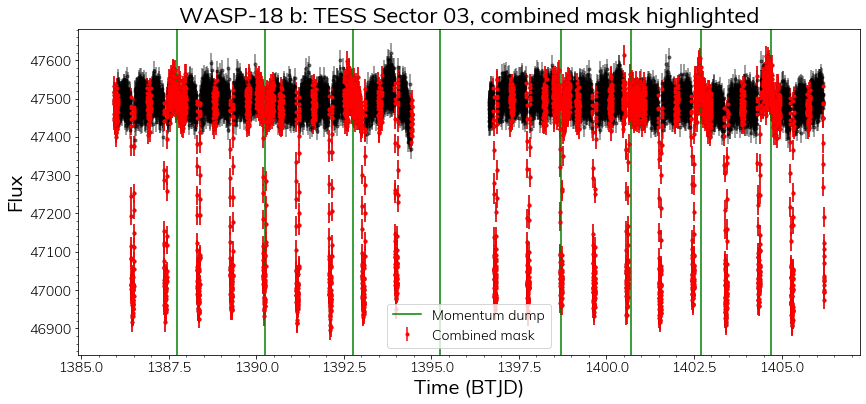

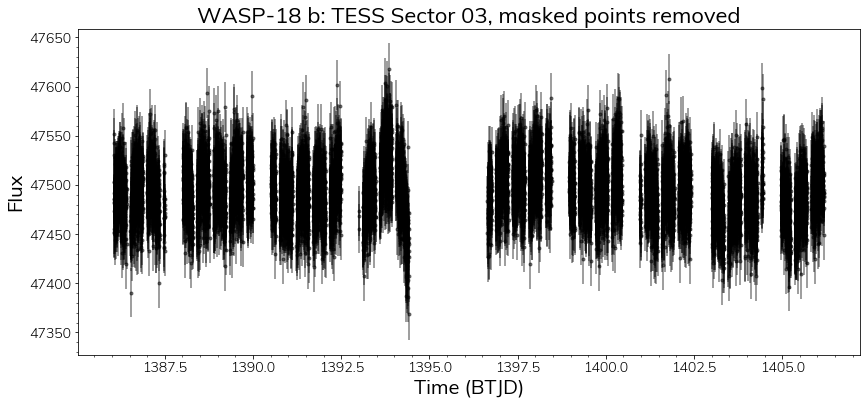

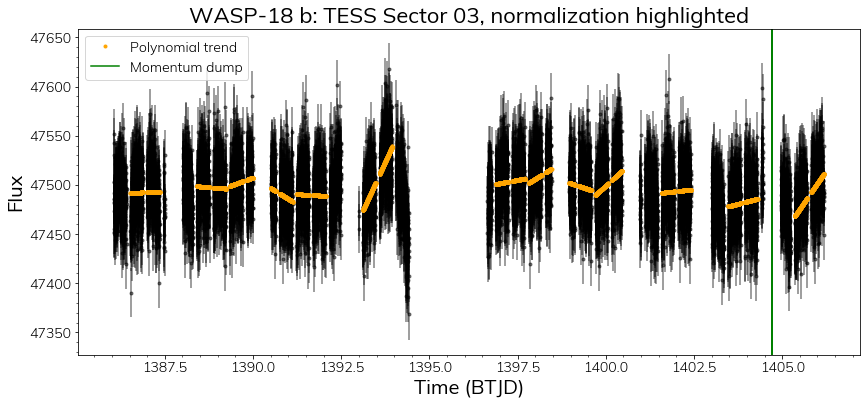

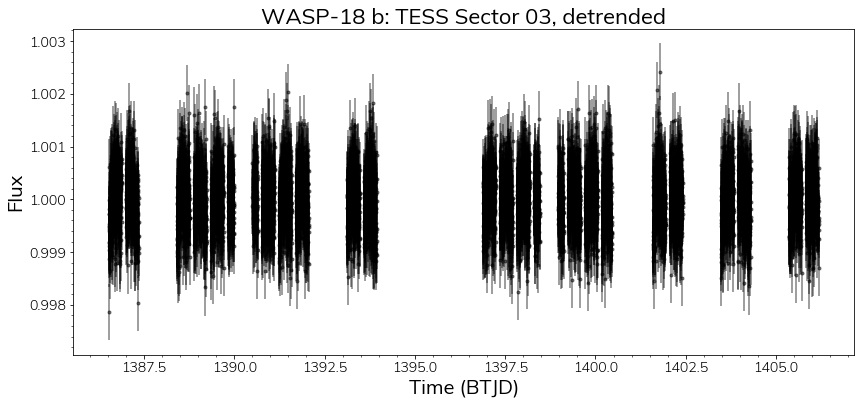

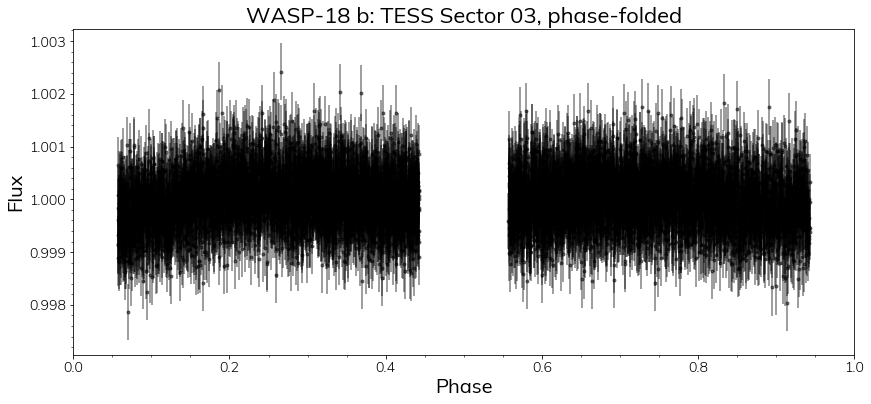

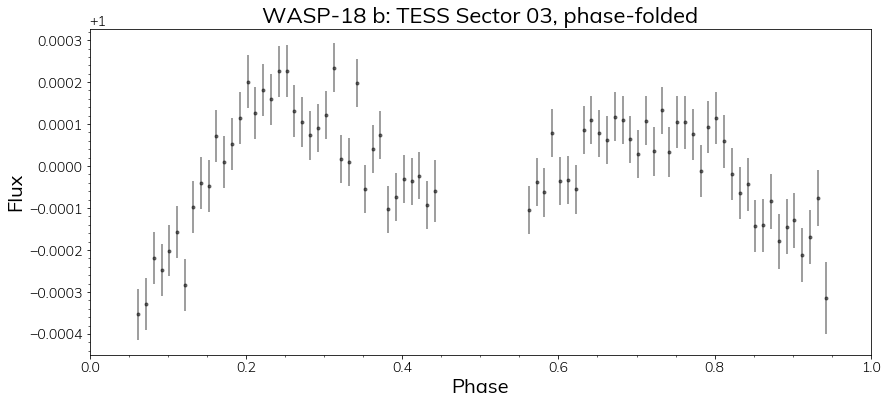

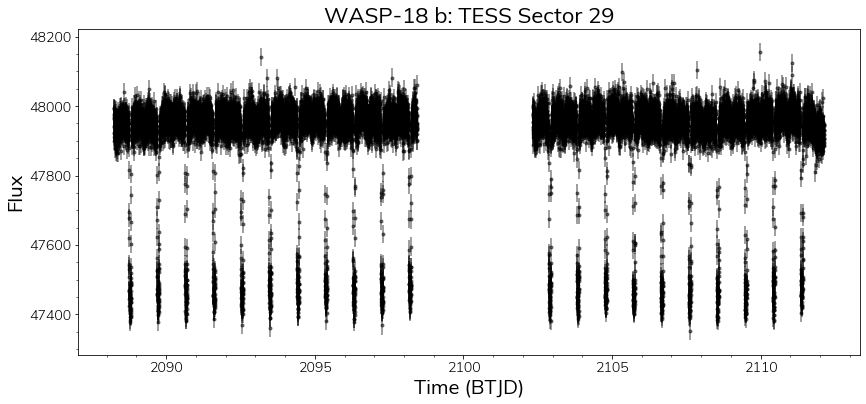

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


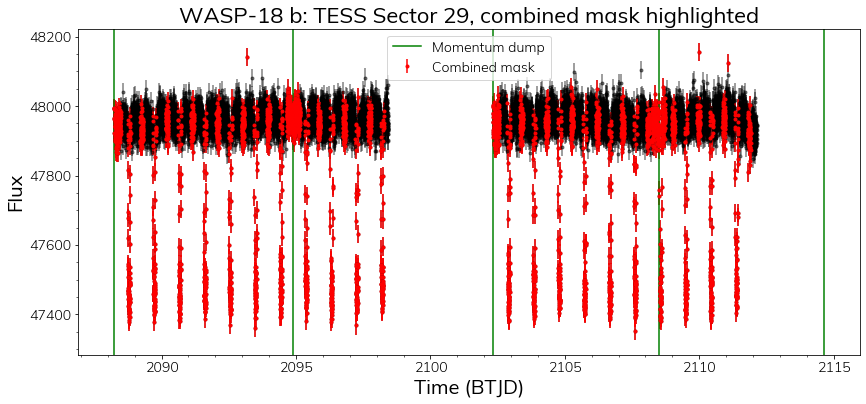

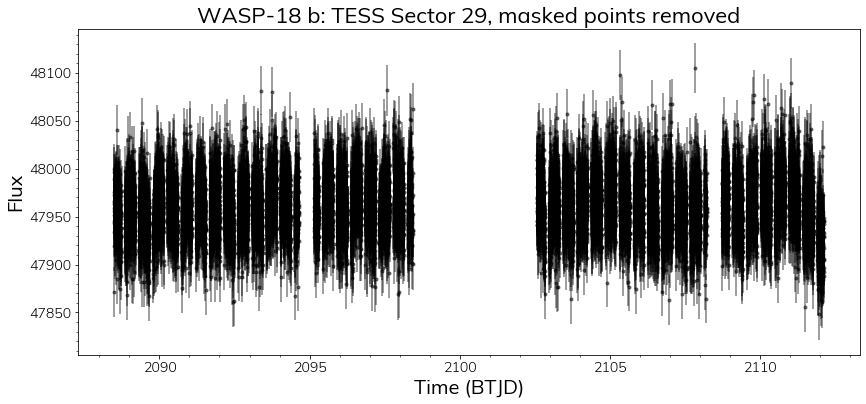

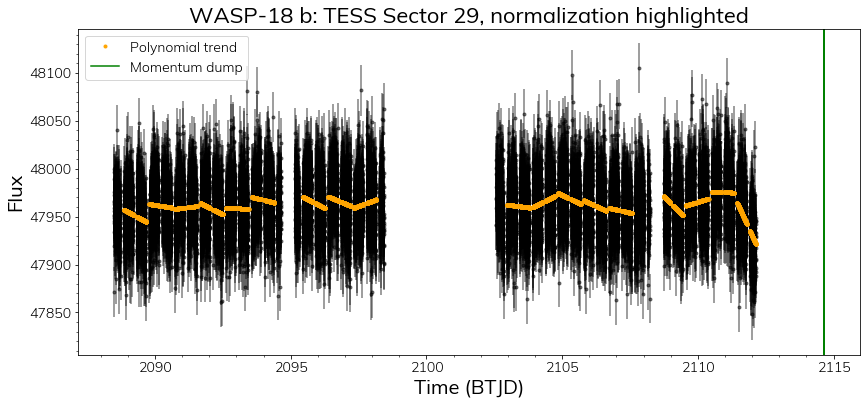

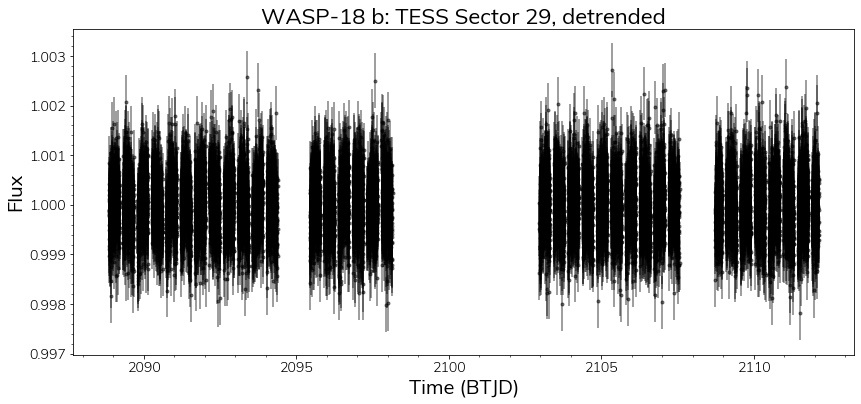

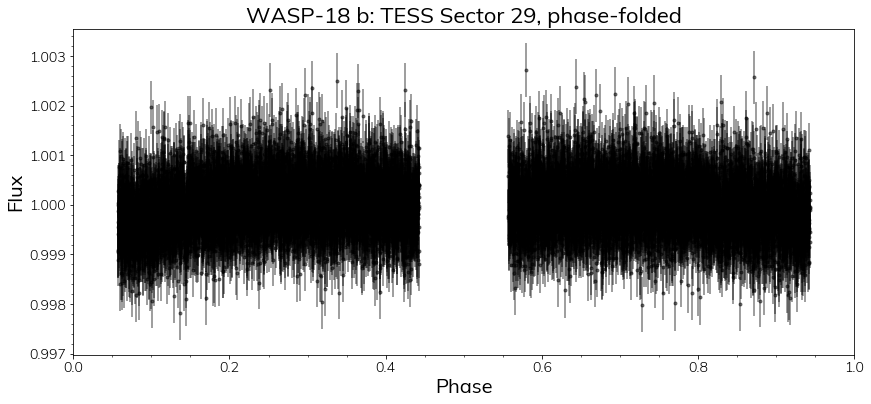

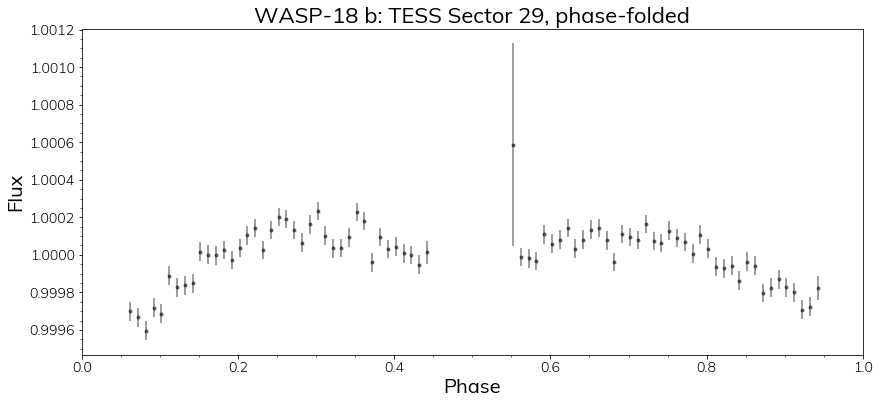

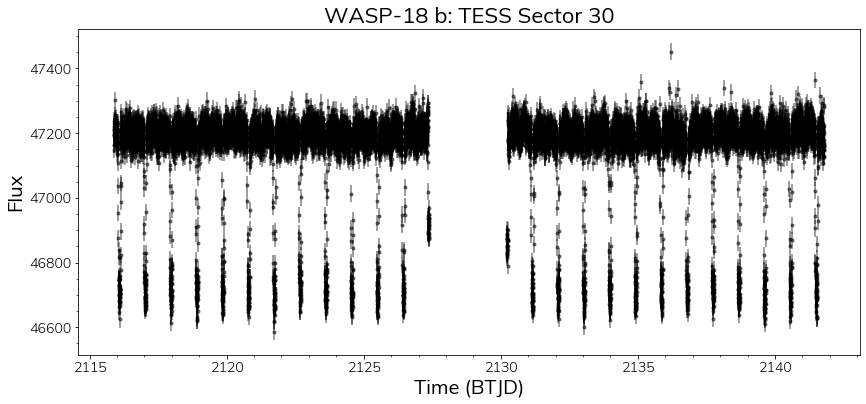

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


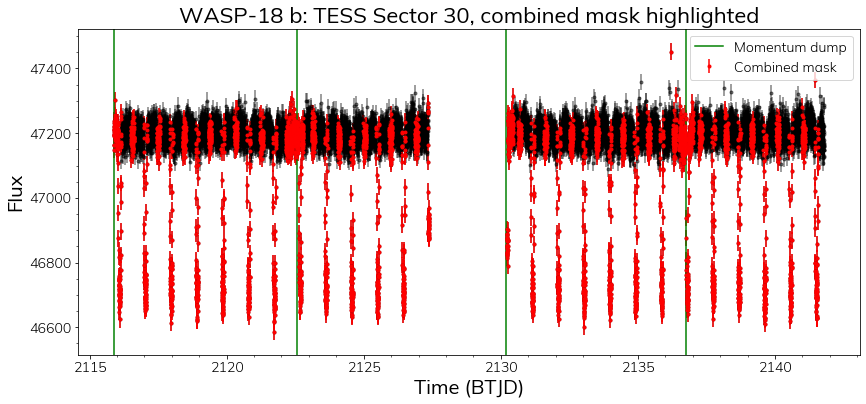

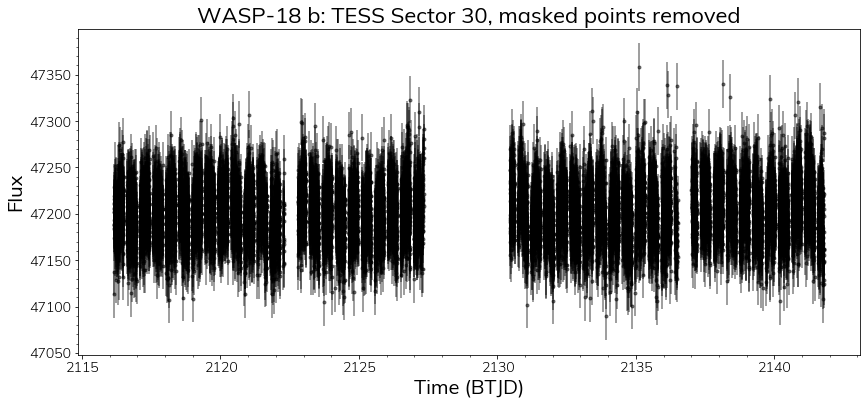

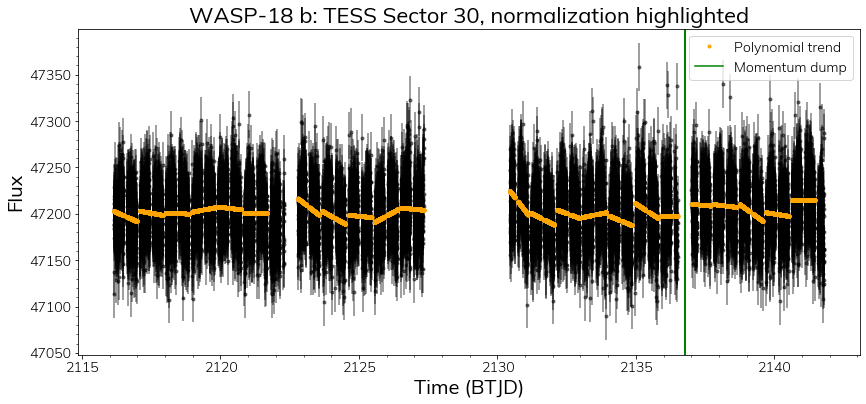

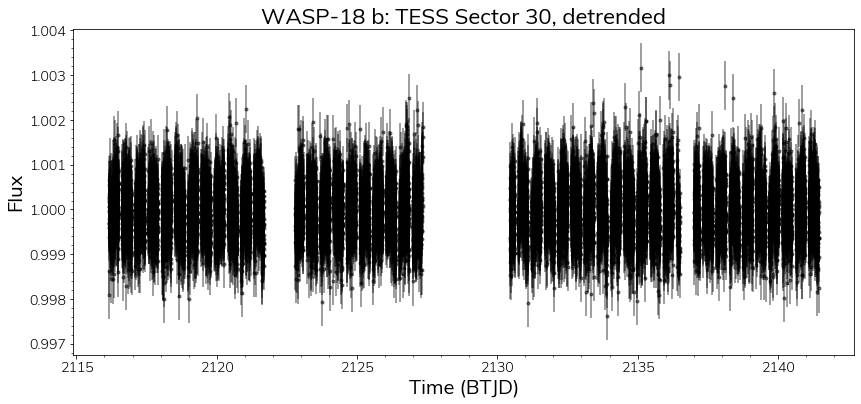

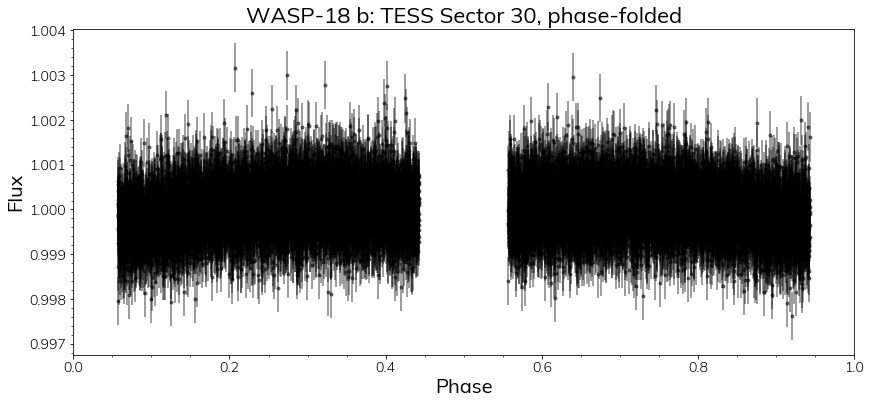

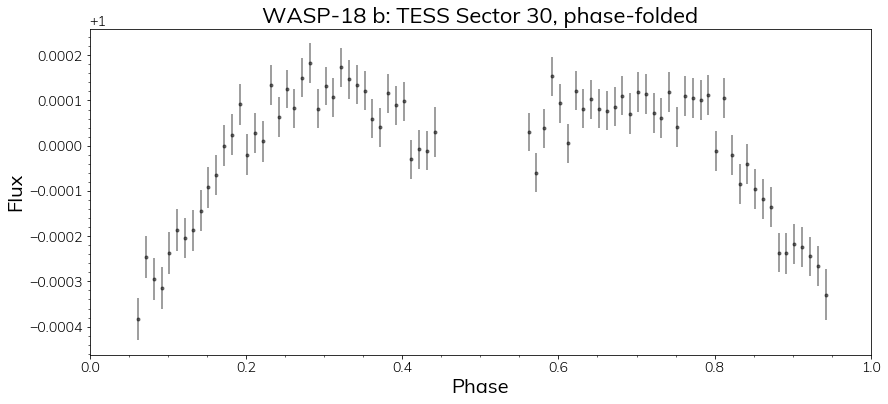

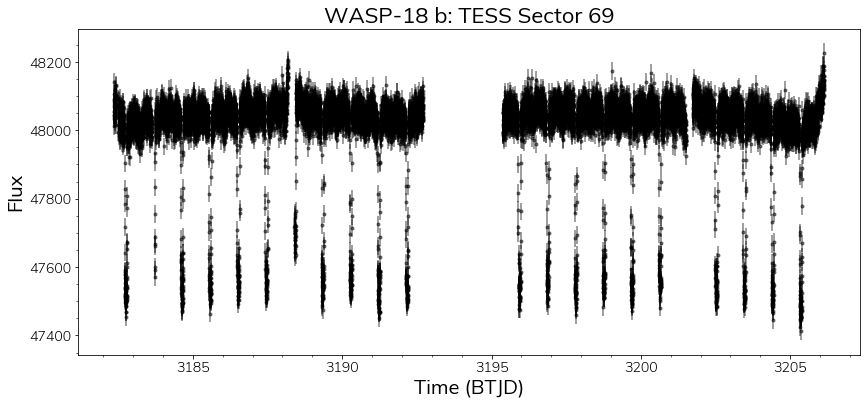

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


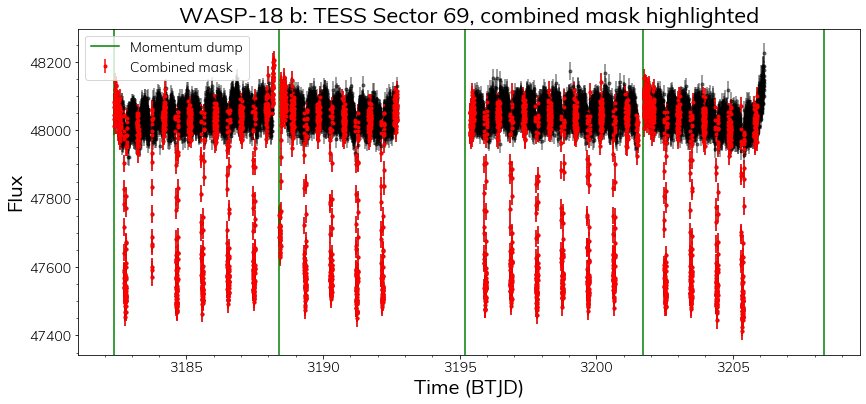

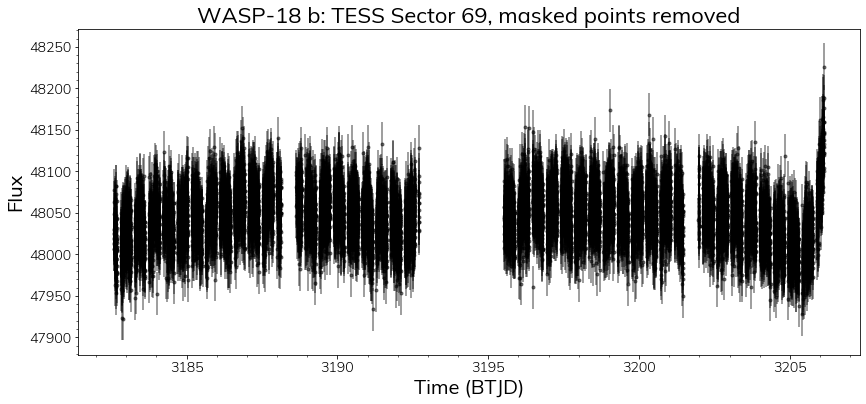

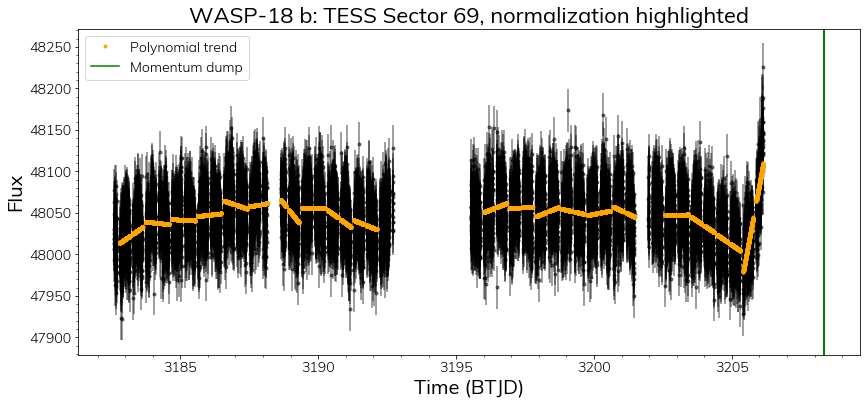

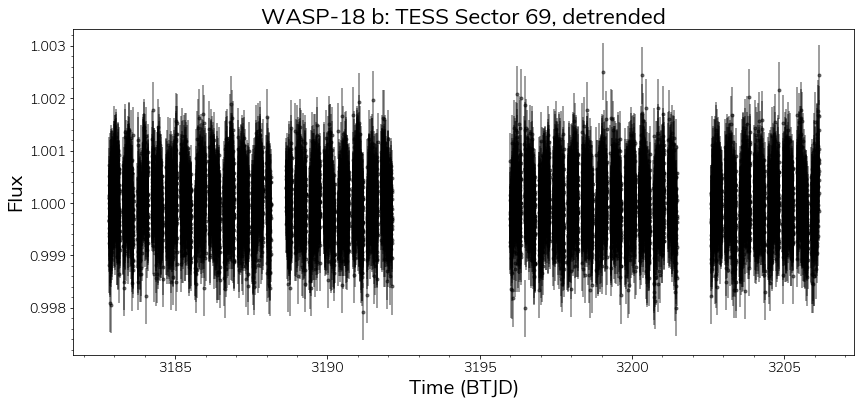

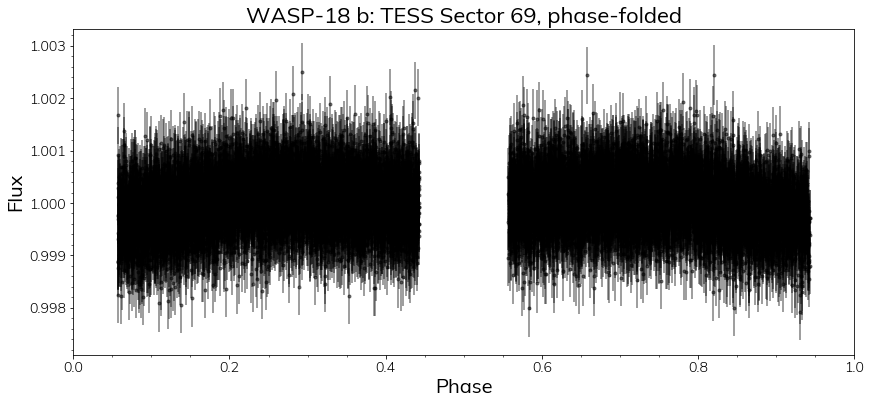

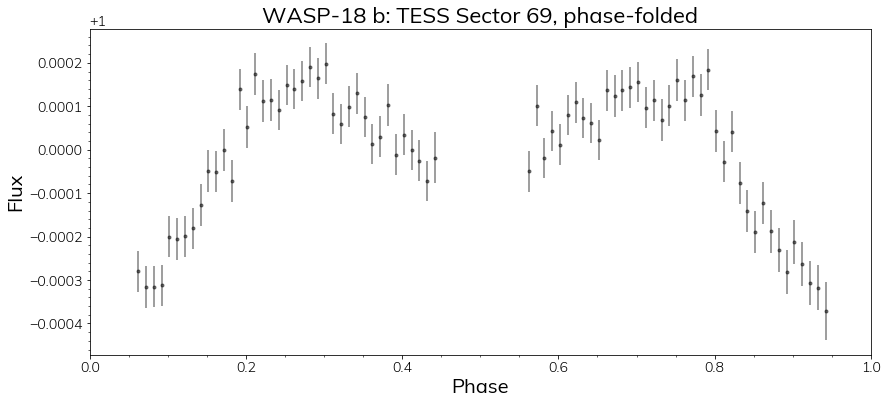

In [7]:
### ALL SECTORS ###

# Download the table of momentum dumps
url = 'https://tess.mit.edu/public/files/Table_of_momentum_dumps.csv'
filename = 'Table_of_momentum_dumps.csv'
fullfilename = os.path.join(os.getcwd(), filename) # Path at which to save the file
urlretrieve(url, fullfilename); # Retrieves and saves the file locally

# Read in momentum dumps
momentum_dumps = np.genfromtxt(filename, delimiter=',', comments='#') # Read table

# Array of flux ramps
flux_ramps = np.array([[0,0]])               
        
# Initialize a dictionary to save the data 
df_dict = {
    'sector': np.array([]),
    'time': np.array([]),
    'phase': np.array([]),
    'flux_raw': np.array([]),
    'flux': np.array([]),
    'flux_err': np.array([])
}

# Loop through all sectors
for sector_ind in range(len(TESS_result)):
    
    # Select the sector
    sector = TESS_result.mission[sector_ind]
    sector_num = int(re.findall(r'\d+', sector)[0])
    
    # Get lightcurve
    lc = TESS_result[sector_ind].download() # By default ignores cadences with severe quality issues
    
    # Change the ND masked arrays to numpy arrays
    lc.time = np.array(lc.time)
    lc.flux = np.array(lc.flux)
    lc.flux_err = np.array(lc.flux_err)
    
    # Plot the lightcurve for visual inspection to identify unexpected phase ramps
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name + ': ' + sector)
    plt.show()
    
    # Mask of bad data quality points
    mask_bad = lc.quality != 0 # Bad data have non-zero quality flags
    
    # Mask of transits and secondary eclipses
    mask_transit = TPC.create_transit_mask(lc, P, t_0, 1.2*t_dur)
    
    # Mask of momentum dumps
    momentum_dumps_times = momentum_dumps[:, 1] # 4th column gives the cadences of the dumps
    momentum_dumps_times = momentum_dumps_times[(momentum_dumps_times > (min(lc.time.value) - 0.25)) & 
                                                (momentum_dumps_times < (max(lc.time.value) + 0.25))] # Select only dumps in sector
    
    # Clean up momentum dump data
    momentum_dumps_times_copy = np.copy(momentum_dumps_times)
    momentum_dumps_times = np.array([])
    
    for time in momentum_dumps_times_copy:
        similar = np.where(abs(momentum_dumps_times_copy - time) <= 0.25)
        momentum_dumps_times = np.hstack([momentum_dumps_times, np.mean(momentum_dumps_times_copy[similar])])
        momentum_dumps_times_copy = np.delete(momentum_dumps_times_copy, similar)
    momentum_dumps_times = np.unique(momentum_dumps_times[~np.isnan(momentum_dumps_times)])
    
    mask_dumps = np.array([False]*len(lc.time.value))
    
    for dump_time in momentum_dumps_times:
        mask_dumps += abs(lc.time.value - dump_time) <= 0.25
        
    # Go through each pair of flux ramp start/end times and mask out the observations that fall in between
    mask_ramps = np.array([False]*len(lc.time.value))
    
    for flux_ramp in flux_ramps:
        ind_ramp = np.argwhere((lc.time.value > flux_ramp[0]) & (lc.time.value < flux_ramp[1]))
        mask_ramps[ind_ramp] = True
        
    # Combined mask
    mask = mask_bad + mask_transit + mask_dumps + mask_ramps
    
    # PLot data with combined mask highlighted in red
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.errorbar(lc.time.value[mask], lc.flux.value[mask], lc.flux_err.value[mask], fmt='.',
                color='r', label='Combined mask')
    for i, dump_time in enumerate(momentum_dumps_times):
        if i == 0:
            plt.axvline(dump_time, color='g', label='Momentum dump')
        else:
            plt.axvline(dump_time, color='g')
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name + ': ' + sector + ', combined mask highlighted')
    plt.legend(fontsize=14)
    plt.show()
    
    # Removed masked points
    lc = lc[~mask]
    
    # Plot data with masked points removed
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name + ': ' + sector + ', masked points removed')
    plt.show()
    
    # Normalize/long-term detrending across momentum dumps
    normalization = np.array([])
    begin = min(lc.time.value)  
    
    # Identify mid-transit times
    offset = P.value - (lc.time.value[0] - t_0.value)%P.value
    times_mid = np.arange(lc.time.value[0]+offset, lc.time.value[-1], P.value)
    
    for i, t_mid in enumerate(times_mid):
        SSE_best, normalization_best, deg_best = np.inf, None, None
        
        ## Loop first segment to second to last segment ##
        
        # Select data within a given orbit
        segment = (lc.time.value >= begin) * (lc.time.value < t_mid)
        if np.sum(segment) == 0:
            continue 
        time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]         
        
        # NaN normalization for segments with less than half an orbital period's worth of data
        normalization_mask = flux_segment == np.nan
        half_orbit_num = ((P.value/2.)*3600*24)/120.
        if len(time_segment[~normalization_mask]) < half_orbit_num:
            normalization_best = np.nan * np.ones_like(time_segment)
            normalization = np.hstack([normalization, normalization_best])
            begin = np.copy(t_mid)           
        else:           
            # Linear fit to each orbit
            p = np.polyfit(time_segment, flux_segment, 1)
            f = np.poly1d(p)
            normalization_best = f(time_segment)
            normalization = np.hstack([normalization, normalization_best])
            begin = np.copy(t_mid)
    
    ### Last segment start ###

    # Select data within a given momentum dump segment
    segment = (lc.time.value > times_mid[-1])
    time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]
    
    # NaN normalization for segments with less than half an orbital period's worth of data
    normalization_mask = flux_segment == np.nan
    half_orbit_num = ((P.value/2.)*3600*24)/120.
    if len(time_segment[~normalization_mask]) < half_orbit_num:
        normalization_best = np.nan * np.ones_like(time_segment)
        normalization = np.hstack([normalization, normalization_best])
    else:
        # Linear fit to each orbit
        p = np.polyfit(time_segment, flux_segment, 1)
        f = np.poly1d(p)
        normalization_best = f(time_segment)
        normalization = np.hstack([normalization, normalization_best])
        begin = np.copy(t_mid)

    ### Last segment finish ###

    # Plot lightcurve with observations with normalization continuum
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=0)
    plt.plot(lc.time.value, normalization, '.', color='orange', label='Polynomial trend')
    for i, t_mid in enumerate(times_mid):
        if i == 0:
            plt.axvline(dump_time, color='g', label='Momentum dump')
        else:
            plt.axvline(dump_time, color='g')
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name+': '+sector+', normalization highlighted')
    plt.legend(fontsize=14)
    plt.show()
    
    # Normalize lightcurve
    flux_raw = lc.flux[~np.isnan(normalization)]
    lc = lc/normalization
    lc = lc[~np.isnan(lc.flux)]
    
    # Plot detrended lightcurve
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name+': '+sector+', detrended')
    plt.show()

    # Phase-fold
    lc_fold = TPC.fold_lk(lc, P, t_0)
    
    # Plot phase-folded lightcurve
    plt.figure(figsize=(14,6))
    plt.errorbar(lc_fold.time.value, lc_fold.flux.value, lc_fold.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.xlim(0, 1)
    plt.title(planet_name+': '+sector+', phase-folded')
    plt.show()
    
    # Plot phase-folded lightcurve
    bin_width = 0.01 * u.day
    lc_bin = lc_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmean)
    plt.figure(figsize=(14,6))
    plt.errorbar(lc_bin.time.value, lc_bin.flux.value, lc_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.xlim(0, 1)
    plt.title(planet_name+': '+sector+', phase-folded')
    plt.show()

    df_dict['sector'] = np.int64(np.hstack([df_dict['sector'], sector_num*np.ones_like(lc.time.value)]))
    df_dict['time'] = np.hstack([df_dict['time'], lc.time.value])
    df_dict['phase'] = np.hstack([df_dict['phase'], lc_fold.time.value])
    df_dict['flux_raw'] = np.hstack([df_dict['flux_raw'], flux_raw])
    df_dict['flux'] = np.hstack([df_dict['flux'], lc.flux.value])
    df_dict['flux_err'] = np.hstack([df_dict['flux_err'], lc.flux_err.value])
    
# Make header
header_str = '# '+planet_name+'\n'
header_str = header_str + '# Reference: ' + NEA_result['pl_refname'][ephemeris_ind] + '\n'
header_str = header_str + '# Transit duration reference: ' + NEA_result['pl_refname'][t_dur_ind] + '\n'
header_str = header_str + '# Period: ' + str(P.value) + '\n'
header_str = header_str + '# Mid-transit time: ' + str(t_0.value) + '\n'
header_str = header_str + '# Transit duration: ' + str(t_dur.value) + '\n'
header_str = header_str + 'sector,time,phase,flux_raw,flux,flux_err\n'

# Save data
template_filename = 'lightcurves/' + planet_name.replace(" ", "") + '.csv'
df = pd.DataFrame(df_dict)
with open(template_filename, 'w') as f:# Append
    f.write(header_str)
    df.to_csv(f, mode='a', header=False, index=False);
    f.close()

Period:  0.94145299 d
t_0:  2454221.48163 d
Transit duration:  2.14368 h


/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


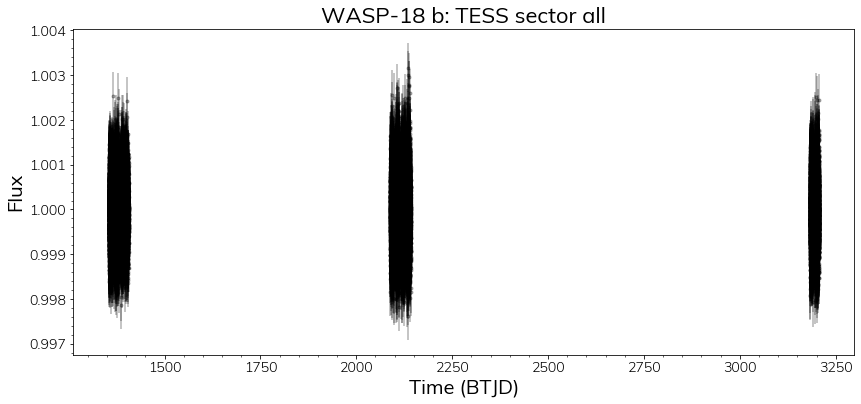

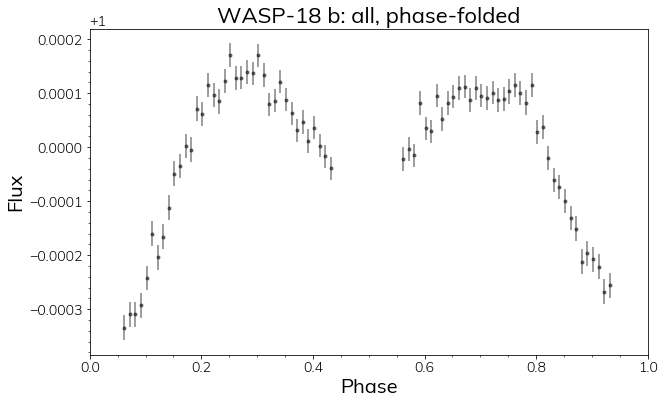

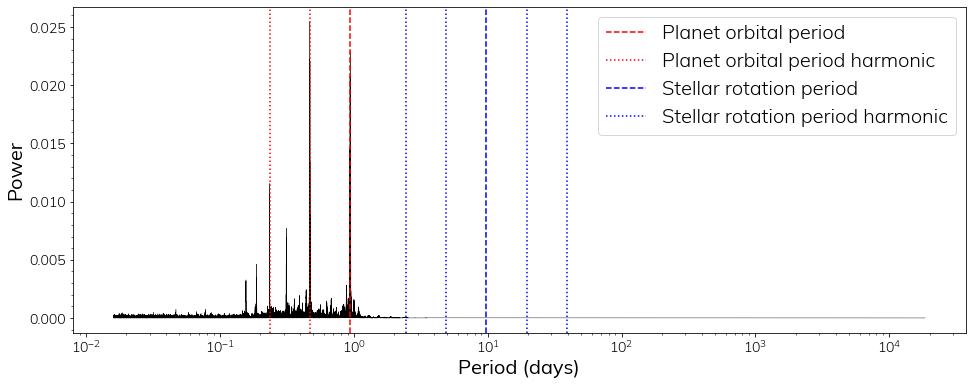

In [19]:
### Read in data ###

planet_name = 'WASP-18 b'
P_rot = 9.8

# NEA_result = NasaExoplanetArchive.query_object(planet_name)
# TIC_id = NEA_result['tic_id'][0] # extracts the TESS Input Catalog ID number associated with the planet
# ephemeris_ind = 1
# # Extract orbital period (P), mid-transit time (t_0), and transit duration (t_dur)
# P, t_0, t_dur = NEA_result['pl_orbper'][ephemeris_ind], NEA_result['pl_tranmid'][ephemeris_ind], \
# NEA_result['pl_trandur'][ephemeris_ind].value*u.hour
# print('Period: ', P)
# print('t_0: ', t_0)
# print('Transit duration: ', t_dur)
# t_0 = t_0 - 2457000.0*u.day

df = pd.read_csv('lightcurves/'+planet_name.replace(" ", "")+'.csv', comment='#', header=0)
sectors = np.unique(df.sector)
sector_ind = 'all' # set between 0 and len(sectors) to select an individual sector, set to 'all' for all sectors

if sector_ind == 'all':
    sector = 'all'
    time = np.array(df.time)
    flux = np.array(df.flux)
    flux_raw = np.array(df.flux_raw)
    flux_err = np.array(df.flux_err)
else:
    sector = sectors[sector_ind]
    sector_bool = df.sector == sector
    time = np.array(df.time)[sector_bool]
    flux = np.array(df.flux)[sector_bool]
    flux_raw = np.array(df.flux_raw)[sector_bool]
    flux_err = np.array(df.flux_err)[sector_bool]        

# Store data as a Lightkurve object to make it easier for phase-folding
lc_data = {'time': time,
           'flux': flux,
           'flux_err': flux_err
          }
lc_data = lk.LightCurve(lc_data)


bin_width = 0.01 * u.day
lc_data_fold = TPC.fold_lk(lc_data, P, t_0)
lc_data_med = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmean)

mask = lc_data_med.flux_err > np.nanmean(lc_data_med.flux_err) + 3*np.nanstd(lc_data_med.flux_err)
lc_data_med = lc_data_med[~mask]

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': TESS sector '+str(sector))
plt.show()

# Plot phase-folded lightcurve
plt.figure(figsize=(10,6))
plt.errorbar(lc_data_med.time.value, lc_data_med.flux.value, lc_data_med.flux_err.value,
             fmt='.', color='k', alpha=0.5, label='median')
# plt.axvspan(0.5-(t_dur.to(u.day).value/(2*P.value)), 0.5+(t_dur.to(u.day).value/(2*P.value)))
# plt.axvspan(0, 0. + (t_dur.to(u.day).value/(2*P.value)))
# plt.axvspan(1. - (t_dur.to(u.day).value/(2*P.value)), 1)
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0, 1)
plt.title(planet_name+': '+str(sector)+', phase-folded')
plt.show()

# Periodogram of raw lightcurve
nout = 10000
w = np.linspace(1e-4, 4, nout)
time = lc_data.time.value[~np.isnan(lc_data.flux.value)]
frequency, power = LombScargle(time, flux).autopower()

plt.figure(figsize=(16, 6))
plt.plot(1/frequency, power, 'k', linewidth=0.4)
plt.axvline(P.value, linestyle='dashed', color='r', label='Planet orbital period')
plt.axvline(P.value/2, linestyle='dotted', color='r', label='Planet orbital period harmonic')
plt.axvline(P.value/4, linestyle='dotted', color='r')

plt.axvline(P_rot, linestyle='dashed', color='b', label='Stellar rotation period')
plt.axvline(P_rot*0.25, linestyle='dotted', color='b', label='Stellar rotation period harmonic')
plt.axvline(P_rot*0.5, linestyle='dotted', color='b')
plt.axvline(P_rot*2, linestyle='dotted', color='b')
plt.axvline(P_rot*4, linestyle='dotted', color='b')

plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend(fontsize=20)
plt.show()